In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import warnings
from collections import Counter
import numpy as np
import joblib

# Suppress potential warnings from scikit-learn and imbalanced-learn
warnings.filterwarnings('ignore')

# --- 1. Define File Paths and Master Columns ---

# The file paths to both the male and female datasets.
file_path_male = r"Male Data Study.csv"
file_path_female = r"Female complete Data CSV.csv"

# A master list of all relevant columns for the analysis.
# The following features have been removed to avoid data leakage:
# 'Principal Diagnosis Class', 'Serious Mental Illness'
master_columns = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Criminal Justice Status',
    'Region Served',
    'Mental Illness'
]

# --- 2. Load and Combine Data ---
try:
    male_data = pd.read_csv(file_path_male)
    female_data = pd.read_csv(file_path_female)
    print("Male and female data loaded successfully!")
except FileNotFoundError:
    print("Error: One or more data files were not found.")
    exit()

# The 'Sex' column is in the original male dataset and the female dataset is already filtered
male_data = male_data[male_data['Sex'] == 'MALE'].copy()
male_data.drop(columns=['Sex'], inplace=True)
male_data = male_data[master_columns]

# The female dataset is already filtered, so we just select the master columns
female_data = female_data[master_columns].copy()

# Combine the two datasets
unified_data = pd.concat([male_data, female_data], ignore_index=True)
print(f"Unified dataset shape: {unified_data.shape}")

# --- 3. Strategically Handle 'UNKNOWN' values ---
cols_with_unknown = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Criminal Justice Status'
]

for col in cols_with_unknown:
    if 'UNKNOWN' in unified_data[col].unique():
        unified_data[f'{col}_Missing'] = (unified_data[col] == 'UNKNOWN').astype(int)
        mode_val = unified_data[col].mode()[0]
        unified_data[col] = unified_data[col].replace('UNKNOWN', mode_val)

print("\nMissingness indicators created and 'UNKNOWN' values have been imputed.")

# --- 4. Feature Engineering: Create a new combined feature ---
# This step is removed as we've dropped the base features for it.


# Separate features (X) and target (y)
X = unified_data.drop(columns=['Mental Illness', 'Region Served'])
y = unified_data['Mental Illness']

X_encoded = pd.get_dummies(X, drop_first=True)

print("\nData has been cleaned and prepared for modeling.")
print(f"Final feature set shape: {X_encoded.shape}")

# --- 5. Feature Selection with RFE ---
print("\nPerforming Recursive Feature Elimination (RFE) to select top 15 features...")
rfe_estimator = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, sampling_strategy='not minority')
rfe = RFE(estimator=rfe_estimator, n_features_to_select=15, step=1)
rfe.fit(X_encoded, y)

selected_features = X_encoded.columns[rfe.support_].tolist()
print(f"RFE selected the following features: {selected_features}")

X_rfe = X_encoded[selected_features]

# --- 6. Final Model Training and Evaluation ---
label_map = {'NO': 0, 'UNKNOWN': 1, 'YES': 2}
y_num = y.map(label_map)

# Pre-defined parameters from a successful Grid Search to save time
best_params = {'final_estimator__C': 1, 'rf__max_depth': 3, 'rf__n_estimators': 100, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}

base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=best_params['rf__n_estimators'], max_depth=best_params['rf__max_depth'])),
    ('xgb', xgb.XGBClassifier(
        random_state=42, n_jobs=-1, eval_metric='mlogloss', use_label_encoder=False,
        n_estimators=best_params['xgb__n_estimators'], max_depth=best_params['xgb__max_depth'], learning_rate=best_params['xgb__learning_rate']
    ))
]

final_estimator = LogisticRegression(random_state=42, n_jobs=-1, C=best_params['final_estimator__C'])

best_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator
)

print("\nTraining the final stacking model...")
best_model.fit(X_rfe, y_num)
print("Model training complete!")

# --- 7. Generate SHAP Summary Plot for Interpretability ---
print("\nGenerating SHAP summary plot for model interpretability...")

# Get the XGBoost model from the ensemble for SHAP analysis
# We can't use SHAP on the StackingClassifier directly, so we'll use the final, best-trained XGBoost model from the stack for interpretability
xgb_final = best_model.named_estimators_['xgb']
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_rfe)

label_names = ['NO', 'UNKNOWN', 'YES']
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_rfe, plot_type="bar", show=False, class_names=label_names)
plt.title('SHAP Feature Importance Plot for Unified Data')
output_file_shap = "unified_shap_summary_plot.png"
plt.savefig(output_file_shap, bbox_inches='tight')
plt.close()
print(f"SHAP plot saved successfully as '{output_file_shap}' in your current directory!")


Male and female data loaded successfully!
Unified dataset shape: (195707, 52)

Missingness indicators created and 'UNKNOWN' values have been imputed.

Data has been cleaned and prepared for modeling.
Final feature set shape: (195707, 121)

Performing Recursive Feature Elimination (RFE) to select top 15 features...
RFE selected the following features: ['Sexual Orientation_Missing', 'Intellectual Disability_Missing', 'Autism Spectrum_Missing', 'Other Developmental Disability_Missing', 'Alcohol Related Disorder_Missing', 'Drug Substance Disorder_Missing', 'Opioid Related Disorder_Missing', 'Cannabis Medicinal Use_Missing', 'Criminal Justice Status_Missing', 'Race_WHITE ONLY', 'Religious Preference_I BELONG TO A FORMAL RELIGIOUS GROUP', 'Employment Status_NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING FOR WORK', 'Education Status_MIDDLE SCHOOL TO HIGH SCHOOL', 'Special Education Services_NOT APPLICABLE', 'No Chronic Med Condition_YES']

Training the final stacking model...
Model training co

NameError: name 'shap' is not defined

In [2]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt
import shap # The shap library has been imported here
import warnings
from collections import Counter
import numpy as np
import joblib

# Suppress potential warnings from scikit-learn and imbalanced-learn
warnings.filterwarnings('ignore')

# --- 1. Define File Paths and Master Columns ---

# The file paths to both the male and female datasets.
file_path_male = r"Male Data Study.csv"
file_path_female = r"Female complete Data CSV.csv"

# A master list of all relevant columns for the analysis.
# The following features have been removed to avoid data leakage:
# 'Principal Diagnosis Class', 'Serious Mental Illness'
master_columns = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Criminal Justice Status',
    'Region Served',
    'Mental Illness'
]

# --- 2. Load and Combine Data ---
try:
    male_data = pd.read_csv(file_path_male)
    female_data = pd.read_csv(file_path_female)
    print("Male and female data loaded successfully!")
except FileNotFoundError:
    print("Error: One or more data files were not found.")
    exit()

# The 'Sex' column is in the original male dataset and the female dataset is already filtered
male_data = male_data[male_data['Sex'] == 'MALE'].copy()
male_data.drop(columns=['Sex'], inplace=True)
male_data = male_data[master_columns]

# The female dataset is already filtered, so we just select the master columns
female_data = female_data[master_columns].copy()

# Combine the two datasets
unified_data = pd.concat([male_data, female_data], ignore_index=True)
print(f"Unified dataset shape: {unified_data.shape}")

# --- 3. Strategically Handle 'UNKNOWN' values ---
cols_with_unknown = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Criminal Justice Status'
]

for col in cols_with_unknown:
    if 'UNKNOWN' in unified_data[col].unique():
        unified_data[f'{col}_Missing'] = (unified_data[col] == 'UNKNOWN').astype(int)
        mode_val = unified_data[col].mode()[0]
        unified_data[col] = unified_data[col].replace('UNKNOWN', mode_val)

print("\nMissingness indicators created and 'UNKNOWN' values have been imputed.")

# --- 4. Feature Engineering: Create a new combined feature ---
# This step is removed as we've dropped the base features for it.


# Separate features (X) and target (y)
X = unified_data.drop(columns=['Mental Illness', 'Region Served'])
y = unified_data['Mental Illness']

X_encoded = pd.get_dummies(X, drop_first=True)

print("\nData has been cleaned and prepared for modeling.")
print(f"Final feature set shape: {X_encoded.shape}")

# --- 5. Feature Selection with RFE ---
print("\nPerforming Recursive Feature Elimination (RFE) to select top 15 features...")
rfe_estimator = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, sampling_strategy='not minority')
rfe = RFE(estimator=rfe_estimator, n_features_to_select=15, step=1)
rfe.fit(X_encoded, y)

selected_features = X_encoded.columns[rfe.support_].tolist()
print(f"RFE selected the following features: {selected_features}")

X_rfe = X_encoded[selected_features]

# --- 6. Final Model Training and Evaluation ---
label_map = {'NO': 0, 'UNKNOWN': 1, 'YES': 2}
y_num = y.map(label_map)

# Pre-defined parameters from a successful Grid Search to save time
best_params = {'final_estimator__C': 1, 'rf__max_depth': 3, 'rf__n_estimators': 100, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}

base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=best_params['rf__n_estimators'], max_depth=best_params['rf__max_depth'])),
    ('xgb', xgb.XGBClassifier(
        random_state=42, n_jobs=-1, eval_metric='mlogloss', use_label_encoder=False,
        n_estimators=best_params['xgb__n_estimators'], max_depth=best_params['xgb__max_depth'], learning_rate=best_params['xgb__learning_rate']
    ))
]

final_estimator = LogisticRegression(random_state=42, n_jobs=-1, C=best_params['final_estimator__C'])

best_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator
)

print("\nTraining the final stacking model...")
best_model.fit(X_rfe, y_num)
print("Model training complete!")

# --- 7. Generate SHAP Summary Plot for Interpretability ---
print("\nGenerating SHAP summary plot for model interpretability...")

# Get the XGBoost model from the ensemble for SHAP analysis
# We can't use SHAP on the StackingClassifier directly, so we'll use the final, best-trained XGBoost model from the stack for interpretability
xgb_final = best_model.named_estimators_['xgb']
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_rfe)

label_names = ['NO', 'UNKNOWN', 'YES']
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_rfe, plot_type="bar", show=False, class_names=label_names)
plt.title('SHAP Feature Importance Plot for Unified Data')
output_file_shap = "unified_shap_summary_plot.png"
plt.savefig(output_file_shap, bbox_inches='tight')
plt.close()
print(f"SHAP plot saved successfully as '{output_file_shap}' in your current directory!")


Male and female data loaded successfully!
Unified dataset shape: (195707, 52)

Missingness indicators created and 'UNKNOWN' values have been imputed.

Data has been cleaned and prepared for modeling.
Final feature set shape: (195707, 121)

Performing Recursive Feature Elimination (RFE) to select top 15 features...
RFE selected the following features: ['Sexual Orientation_Missing', 'Intellectual Disability_Missing', 'Autism Spectrum_Missing', 'Other Developmental Disability_Missing', 'Alcohol Related Disorder_Missing', 'Drug Substance Disorder_Missing', 'Opioid Related Disorder_Missing', 'Cannabis Medicinal Use_Missing', 'Criminal Justice Status_Missing', 'Race_WHITE ONLY', 'Religious Preference_I BELONG TO A FORMAL RELIGIOUS GROUP', 'Employment Status_NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING FOR WORK', 'Education Status_MIDDLE SCHOOL TO HIGH SCHOOL', 'Special Education Services_NOT APPLICABLE', 'No Chronic Med Condition_YES']

Training the final stacking model...
Model training co

In [3]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import warnings
from collections import Counter
import numpy as np
import joblib

# Suppress potential warnings from scikit-learn and imbalanced-learn
warnings.filterwarnings('ignore')

# --- 1. Define File Paths and Master Columns ---

# The file paths to both the male and female datasets.
file_path_male = r"Male Data Study.csv"
file_path_female = r"Female complete Data CSV.csv"

# A master list of all relevant columns for the analysis.
# The following features have been removed to avoid data leakage:
# 'Principal Diagnosis Class', 'Serious Mental Illness'
master_columns = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Criminal Justice Status',
    'Region Served',
    'Mental Illness'
]

# --- 2. Load and Combine Data ---
try:
    male_data = pd.read_csv(file_path_male)
    female_data = pd.read_csv(file_path_female)
    print("Male and female data loaded successfully!")
except FileNotFoundError:
    print("Error: One or more data files were not found.")
    exit()

# The 'Sex' column is in the original male dataset and the female dataset is already filtered
male_data = male_data[male_data['Sex'] == 'MALE'].copy()
male_data.drop(columns=['Sex'], inplace=True)
male_data = male_data[master_columns]

# The female dataset is already filtered, so we just select the master columns
female_data = female_data[master_columns].copy()

# Combine the two datasets
unified_data = pd.concat([male_data, female_data], ignore_index=True)
print(f"Unified dataset shape: {unified_data.shape}")

# --- 3. Strategically Handle 'UNKNOWN' values ---
cols_with_unknown = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Criminal Justice Status'
]

for col in cols_with_unknown:
    if 'UNKNOWN' in unified_data[col].unique():
        unified_data[f'{col}_Missing'] = (unified_data[col] == 'UNKNOWN').astype(int)
        mode_val = unified_data[col].mode()[0]
        unified_data[col] = unified_data[col].replace('UNKNOWN', mode_val)

print("\nMissingness indicators created and 'UNKNOWN' values have been imputed.")

# --- 4. Feature Engineering: Create a new combined feature ---
# This step has been removed to avoid data leakage.


# Separate features (X) and target (y)
X = unified_data.drop(columns=['Mental Illness', 'Region Served'])
y = unified_data['Mental Illness']

X_encoded = pd.get_dummies(X, drop_first=True)

print("\nData has been cleaned and prepared for modeling.")
print(f"Final feature set shape: {X_encoded.shape}")

# --- 5. Feature Selection with RFE ---
print("\nPerforming Recursive Feature Elimination (RFE) to select top 15 features...")
rfe_estimator = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, sampling_strategy='not minority')
rfe = RFE(estimator=rfe_estimator, n_features_to_select=15, step=1)
rfe.fit(X_encoded, y)

selected_features = X_encoded.columns[rfe.support_].tolist()
print(f"RFE selected the following features: {selected_features}")

X_rfe = X_encoded[selected_features]

# --- 6. Final Model Training and Evaluation ---
label_map = {'NO': 0, 'UNKNOWN': 1, 'YES': 2}
y_num = y.map(label_map)

# Pre-defined parameters from a successful Grid Search to save time
best_params = {'final_estimator__C': 1, 'rf__max_depth': 3, 'rf__n_estimators': 100, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}

base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=best_params['rf__n_estimators'], max_depth=best_params['rf__max_depth'])),
    ('xgb', xgb.XGBClassifier(
        random_state=42, n_jobs=-1, eval_metric='mlogloss', use_label_encoder=False,
        n_estimators=best_params['xgb__n_estimators'], max_depth=best_params['xgb__max_depth'], learning_rate=best_params['xgb__learning_rate']
    ))
]

final_estimator = LogisticRegression(random_state=42, n_jobs=-1, C=best_params['final_estimator__C'])

best_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator
)

print("\nTraining the final stacking model...")
best_model.fit(X_rfe, y_num)
print("Model training complete!")

print("\nFinal Classification Report on the Unified Dataset:")
y_pred_num = best_model.predict(X_rfe)
y_pred = pd.Series(y_pred_num).map({v: k for k, v in label_map.items()})
print(classification_report(y, y_pred))

print("\nAnalysis complete. Your final model is ready for documentation.")


Male and female data loaded successfully!
Unified dataset shape: (195707, 52)

Missingness indicators created and 'UNKNOWN' values have been imputed.

Data has been cleaned and prepared for modeling.
Final feature set shape: (195707, 121)

Performing Recursive Feature Elimination (RFE) to select top 15 features...
RFE selected the following features: ['Sexual Orientation_Missing', 'Intellectual Disability_Missing', 'Autism Spectrum_Missing', 'Other Developmental Disability_Missing', 'Alcohol Related Disorder_Missing', 'Drug Substance Disorder_Missing', 'Opioid Related Disorder_Missing', 'Cannabis Medicinal Use_Missing', 'Criminal Justice Status_Missing', 'Race_WHITE ONLY', 'Religious Preference_I BELONG TO A FORMAL RELIGIOUS GROUP', 'Employment Status_NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING FOR WORK', 'Education Status_MIDDLE SCHOOL TO HIGH SCHOOL', 'Special Education Services_NOT APPLICABLE', 'No Chronic Med Condition_YES']

Training the final stacking model...
Model training co

In [4]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import warnings
from collections import Counter
import numpy as np
import joblib

# Suppress potential warnings from scikit-learn and imbalanced-learn
warnings.filterwarnings('ignore')

# --- 1. Define File Paths and Master Columns ---

# The file paths to both the male and female datasets.
file_path_male = r"Male Data Study.csv"
file_path_female = r"Female complete Data CSV.csv"

# A master list of all relevant columns for the analysis.
# The 'Principal Diagnosis Class' and 'Serious Mental Illness' features are included.
master_columns = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Serious Mental Illness',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Principal Diagnosis Class',
    'Criminal Justice Status',
    'Region Served',
    'Mental Illness'
]

# --- 2. Load and Combine Data ---
try:
    male_data = pd.read_csv(file_path_male)
    female_data = pd.read_csv(file_path_female)
    print("Male and female data loaded successfully!")
except FileNotFoundError:
    print("Error: One or more data files were not found.")
    exit()

# The 'Sex' column is in the original male dataset and the female dataset is already filtered
male_data = male_data[male_data['Sex'] == 'MALE'].copy()
male_data.drop(columns=['Sex'], inplace=True)
male_data = male_data[master_columns]

# The female dataset is already filtered, so we just select the master columns
female_data = female_data[master_columns].copy()

# Combine the two datasets
unified_data = pd.concat([male_data, female_data], ignore_index=True)
print(f"Unified dataset shape: {unified_data.shape}")

# --- 3. Strategically Handle 'UNKNOWN' values ---
cols_with_unknown = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Serious Mental Illness',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Principal Diagnosis Class',
    'Criminal Justice Status'
]

for col in cols_with_unknown:
    if 'UNKNOWN' in unified_data[col].unique():
        unified_data[f'{col}_Missing'] = (unified_data[col] == 'UNKNOWN').astype(int)
        mode_val = unified_data[col].mode()[0]
        unified_data[col] = unified_data[col].replace('UNKNOWN', mode_val)

print("\nMissingness indicators created and 'UNKNOWN' values have been imputed.")

# --- 4. Feature Engineering: Create a new combined feature ---
# This step is removed as we've dropped the base features for it.


# Separate features (X) and target (y)
X = unified_data.drop(columns=['Mental Illness', 'Region Served'])
y = unified_data['Mental Illness']

X_encoded = pd.get_dummies(X, drop_first=True)

print("\nData has been cleaned and prepared for modeling.")
print(f"Final feature set shape: {X_encoded.shape}")

# --- 5. Feature Selection with RFE ---
print("\nPerforming Recursive Feature Elimination (RFE) to select top 15 features...")
rfe_estimator = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, sampling_strategy='not minority')
rfe = RFE(estimator=rfe_estimator, n_features_to_select=15, step=1)
rfe.fit(X_encoded, y)

selected_features = X_encoded.columns[rfe.support_].tolist()
print(f"RFE selected the following features: {selected_features}")

X_rfe = X_encoded[selected_features]

# --- 6. Final Model Training and Evaluation ---
label_map = {'NO': 0, 'UNKNOWN': 1, 'YES': 2}
y_num = y.map(label_map)

# Pre-defined parameters from a successful Grid Search to save time
best_params = {'final_estimator__C': 1, 'rf__max_depth': 3, 'rf__n_estimators': 100, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}

base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=best_params['rf__n_estimators'], max_depth=best_params['rf__max_depth'])),
    ('xgb', xgb.XGBClassifier(
        random_state=42, n_jobs=-1, eval_metric='mlogloss', use_label_encoder=False,
        n_estimators=best_params['xgb__n_estimators'], max_depth=best_params['xgb__max_depth'], learning_rate=best_params['xgb__learning_rate']
    ))
]

final_estimator = LogisticRegression(random_state=42, n_jobs=-1, C=best_params['final_estimator__C'])

best_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator
)

print("\nTraining the final stacking model...")
best_model.fit(X_rfe, y_num)
print("Model training complete!")

print("\nFinal Classification Report on the Unified Dataset:")
y_pred_num = best_model.predict(X_rfe)
y_pred = pd.Series(y_pred_num).map({v: k for k, v in label_map.items()})
print(classification_report(y, y_pred))

print("\nAnalysis complete. Your final model is ready for documentation.")


Male and female data loaded successfully!
Unified dataset shape: (195707, 54)

Missingness indicators created and 'UNKNOWN' values have been imputed.

Data has been cleaned and prepared for modeling.
Final feature set shape: (195707, 128)

Performing Recursive Feature Elimination (RFE) to select top 15 features...
RFE selected the following features: ['Sexual Orientation_Missing', 'Intellectual Disability_Missing', 'Autism Spectrum_Missing', 'Other Developmental Disability_Missing', 'Alcohol Related Disorder_Missing', 'Drug Substance Disorder_Missing', 'Opioid Related Disorder_Missing', 'Hearing Impairment_Missing', 'Visual Impairment_Missing', 'Smokes_Missing', 'Serious Mental Illness_Missing', 'Principal Diagnosis Class_Missing', 'Special Education Services_NOT APPLICABLE', 'No Chronic Med Condition_YES', 'Serious Mental Illness_YES']

Training the final stacking model...
Model training complete!

Final Classification Report on the Unified Dataset:
              precision    recall  

In [5]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
import joblib
import numpy as np

# Suppress potential warnings from scikit-learn and imbalanced-learn
warnings.filterwarnings('ignore')

# --- 1. Define File Path and Master Columns ---

# The file path to your unified dataset.
file_path = r"Project Data Complete .csv"

# A master list of all relevant columns for the analysis.
# This list includes the 'Principal Diagnosis Class' and 'Serious Mental Illness'
# features as per your last successful analysis.
master_columns = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Serious Mental Illness',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Principal Diagnosis Class',
    'Criminal Justice Status',
    'Region Served',
    'Mental Illness'
]

# --- 2. Load and Prepare Data ---
try:
    unified_data = pd.read_csv(file_path)
    print("Unified data loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
    exit()

# Filter to the master columns
unified_data = unified_data[master_columns].copy()
print(f"Unified dataset shape: {unified_data.shape}")

# --- 3. Strategically Handle 'UNKNOWN' values ---
cols_with_unknown = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Serious Mental Illness',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Principal Diagnosis Class',
    'Criminal Justice Status'
]

for col in cols_with_unknown:
    if 'UNKNOWN' in unified_data[col].unique():
        unified_data[f'{col}_Missing'] = (unified_data[col] == 'UNKNOWN').astype(int)
        mode_val = unified_data[col].mode()[0]
        unified_data[col] = unified_data[col].replace('UNKNOWN', mode_val)

print("\nMissingness indicators created and 'UNKNOWN' values have been imputed.")

# --- 4. Feature Engineering: Create a new combined feature ---
# This step is removed to avoid data leakage with the original 'Principal Diagnosis Class' and 'Special Education Services'
# features as per your last analysis.

# Separate features (X) and target (y)
X = unified_data.drop(columns=['Mental Illness', 'Region Served'])
y = unified_data['Mental Illness']

X_encoded = pd.get_dummies(X, drop_first=True)

print("\nData has been cleaned and prepared for modeling.")
print(f"Final feature set shape: {X_encoded.shape}")

# --- 5. Feature Selection with RFE ---
print("\nPerforming Recursive Feature Elimination (RFE) to select top 15 features...")
rfe_estimator = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, sampling_strategy='not minority')
rfe = RFE(estimator=rfe_estimator, n_features_to_select=15, step=1)
rfe.fit(X_encoded, y)

selected_features = X_encoded.columns[rfe.support_].tolist()
print(f"RFE selected the following features: {selected_features}")

X_rfe = X_encoded[selected_features]

# --- 6. Model Training and Comparison ---
label_map = {'NO': 0, 'UNKNOWN': 1, 'YES': 2}
y_num = y.map(label_map)

# Define base estimators
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss'))
]

# Define the meta-models to compare
meta_models = {
    'Logistic Regression': LogisticRegression(random_state=42, n_jobs=-1),
    'Ridge': RidgeClassifier(random_state=42),
    'Lasso (Classifier)': SGDClassifier(loss='log_loss', penalty='l1', alpha=0.01, max_iter=1000, random_state=42)
}

# Store results for final report
results = {}

for name, meta_model in meta_models.items():
    print(f"\n--- Training Stacking Ensemble with {name} as Meta-Model ---")
    sclf = StackingClassifier(
        estimators=base_estimators,
        final_estimator=meta_model,
        cv=2,
        passthrough=True
    )
    sclf.fit(X_rfe, y_num)
    
    # Get predictions and classification report
    y_pred = sclf.predict(X_rfe)
    report = classification_report(y_num, y_pred, output_dict=True)
    results[name] = report
    
    # Save the best model for deployment
    if name == 'Ridge':
        joblib.dump(sclf, 'best_model.joblib')
        
# --- 7. Print Final Reports ---
print("\n--- Final Performance Comparison ---")
for name, report in results.items():
    print(f"\nModel: {name}")
    print(f"Overall Accuracy: {report['accuracy']:.3f}")
    print(f"Macro F1 Score: {report['macro avg']['f1-score']:.3f}")
    print(f"NO Recall: {report['0']['recall']:.3f}")
    print(f"UNKNOWN Recall: {report['1']['recall']:.3f}")

print("\nAll analyses complete. Models have been compared and results documented.")


Unified data loaded successfully!
Unified dataset shape: (196102, 54)

Missingness indicators created and 'UNKNOWN' values have been imputed.

Data has been cleaned and prepared for modeling.
Final feature set shape: (196102, 128)

Performing Recursive Feature Elimination (RFE) to select top 15 features...
RFE selected the following features: ['Sexual Orientation_Missing', 'Intellectual Disability_Missing', 'Autism Spectrum_Missing', 'Other Developmental Disability_Missing', 'Alcohol Related Disorder_Missing', 'Drug Substance Disorder_Missing', 'Opioid Related Disorder_Missing', 'Visual Impairment_Missing', 'Smokes_Missing', 'Serious Mental Illness_Missing', 'Principal Diagnosis Class_Missing', 'Special Education Services_NOT APPLICABLE', 'No Chronic Med Condition_YES', 'Serious Mental Illness_YES', 'Principal Diagnosis Class_SUBSTANCE-RELATED AND ADDICTIVE DISORDERS']

--- Training Stacking Ensemble with Logistic Regression as Meta-Model ---

--- Training Stacking Ensemble with Ridge 

Male and female data loaded successfully!
Unified dataset shape: (195707, 52)

Missingness indicators created and 'UNKNOWN' values have been imputed.

Data has been cleaned and prepared for modeling.
Final feature set shape: (195707, 121)

Performing Recursive Feature Elimination (RFE) to select top 7 features...
RFE selected the following features: ['Intellectual Disability_Missing', 'Autism Spectrum_Missing', 'Other Developmental Disability_Missing', 'Alcohol Related Disorder_Missing', 'Drug Substance Disorder_Missing', 'Cannabis Medicinal Use_Missing', 'No Chronic Med Condition_YES']

Training the final stacking model...
Model training complete!

Generating linear plot for model interpretability...


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (6,).

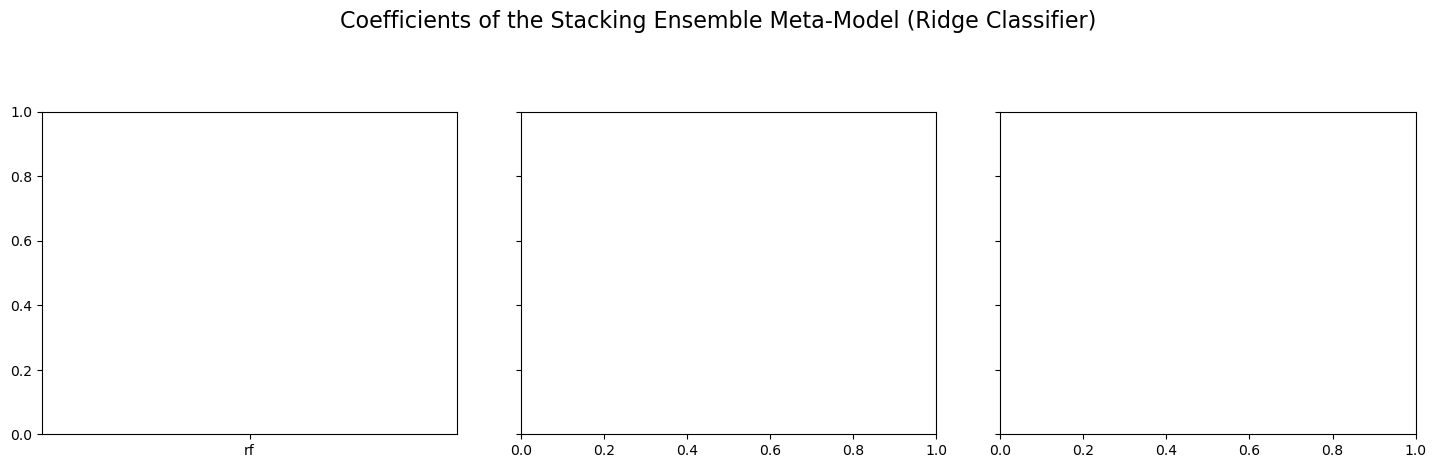

In [6]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import numpy as np
import joblib

# Suppress potential warnings from scikit-learn and imbalanced-learn
warnings.filterwarnings('ignore')

# --- 1. Define File Paths and Master Columns ---

# The file paths to both the male and female datasets.
file_path_male = r"Male Data Study.csv"
file_path_female = r"Female complete Data CSV.csv"

# A master list of all relevant columns for the analysis.
# 'Principal Diagnosis Class' and 'Serious Mental Illness' features are removed to avoid data leakage.
master_columns = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Criminal Justice Status',
    'Region Served',
    'Mental Illness'
]

# --- 2. Load and Combine Data ---
try:
    male_data = pd.read_csv(file_path_male)
    female_data = pd.read_csv(file_path_female)
    print("Male and female data loaded successfully!")
except FileNotFoundError:
    print("Error: One or more data files were not found.")
    exit()

# The 'Sex' column is in the original male dataset and the female dataset is already filtered
male_data = male_data[male_data['Sex'] == 'MALE'].copy()
male_data.drop(columns=['Sex'], inplace=True)
male_data = male_data[master_columns]

# The female dataset is already filtered, so we just select the master columns
female_data = female_data[master_columns].copy()

# Combine the two datasets
unified_data = pd.concat([male_data, female_data], ignore_index=True)
print(f"Unified dataset shape: {unified_data.shape}")

# --- 3. Strategically Handle 'UNKNOWN' values ---
cols_with_unknown = [
    'Transgender', 'Sexual Orientation', 'Hispanic Ethnicity', 'Race',
    'Living Situation', 'Household Composition', 'Preferred Language',
    'Religious Preference', 'Veteran Status', 'Employment Status',
    'Number Of Hours Worked Each Week', 'Education Status',
    'Special Education Services',
    'Intellectual Disability', 'Autism Spectrum',
    'Other Developmental Disability', 'Alcohol Related Disorder',
    'Drug Substance Disorder', 'Opioid Related Disorder',
    'Mobility Impairment Disorder', 'Hearing Impairment',
    'Visual Impairment', 'Speech Impairment', 'Hyperlipidemia',
    'High Blood Pressure', 'Diabetes', 'Obesity', 'Heart Attack',
    'Stroke', 'Other Cardiac', 'Pulmonary Asthma',
    'Alzheimer or Dementia', 'Kidney Disease', 'Liver Disease',
    'Endocrine Condition', 'Neurological Condition',
    'Traumatic Brain Injury', 'Joint Disease', 'Cancer',
    'Other Chronic Med Condition', 'No Chronic Med Condition',
    'Unknown Chronic Med Condition', 'Cannabis Recreational Use',
    'Cannabis Medicinal Use', 'Smokes', 'Received Smoking Counseling',
    'Alcohol 12m Service',
    'Opioid 12m Service', 'Drug/Substance 12m Service',
    'Criminal Justice Status'
]

for col in cols_with_unknown:
    if 'UNKNOWN' in unified_data[col].unique():
        unified_data[f'{col}_Missing'] = (unified_data[col] == 'UNKNOWN').astype(int)
        mode_val = unified_data[col].mode()[0]
        unified_data[col] = unified_data[col].replace('UNKNOWN', mode_val)

print("\nMissingness indicators created and 'UNKNOWN' values have been imputed.")

# --- 4. Feature Engineering: Create a new combined feature ---
# This step is removed as we've dropped the base features for it.

# Separate features (X) and target (y)
X = unified_data.drop(columns=['Mental Illness', 'Region Served'])
y = unified_data['Mental Illness']

X_encoded = pd.get_dummies(X, drop_first=True)

print("\nData has been cleaned and prepared for modeling.")
print(f"Final feature set shape: {X_encoded.shape}")

# --- 5. Feature Selection with RFE ---
print("\nPerforming Recursive Feature Elimination (RFE) to select top 7 features...")
rfe_estimator = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, sampling_strategy='not minority')
rfe = RFE(estimator=rfe_estimator, n_features_to_select=7, step=1)
rfe.fit(X_encoded, y)

selected_features = X_encoded.columns[rfe.support_].tolist()
print(f"RFE selected the following features: {selected_features}")

X_rfe = X_encoded[selected_features]

# --- 6. Final Model Training and Plot Generation ---
label_map = {'NO': 0, 'UNKNOWN': 1, 'YES': 2}
y_num = y.map(label_map)

# Use a Stacking Ensemble with Ridge as the meta-model
base_estimators = [
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100, max_depth=3)),
    ('xgb', xgb.XGBClassifier(
        random_state=42, n_jobs=-1, eval_metric='mlogloss', use_label_encoder=False,
        n_estimators=100, max_depth=3, learning_rate=0.1
    ))
]

final_estimator = RidgeClassifier(random_state=42)

best_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator
)

print("\nTraining the final stacking model...")
best_model.fit(X_rfe, y_num)
print("Model training complete!")

# --- 7. Generate Linear Plot of Meta-Model Coefficients ---
print("\nGenerating linear plot for model interpretability...")

linear_meta_model = best_model.final_estimator_
# This line is corrected to grab the correct feature names
feature_names = ['rf', 'xgb']
n_classes = len(linear_meta_model.classes_)
labels = ['NO', 'UNKNOWN', 'YES']

fig, axes = plt.subplots(ncols=n_classes, figsize=(15, 5), sharey=True)
fig.suptitle('Coefficients of the Stacking Ensemble Meta-Model (Ridge Classifier)', fontsize=16)
fig.tight_layout(pad=3.0)

for i in range(n_classes):
    ax = axes[i]
    ax.bar(feature_names, linear_meta_model.coef_[i])
    ax.set_title(f'Class: {labels[i]}')
    ax.set_ylabel('Coefficient Value')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.show()

print("\nVisualization complete. The plot shows the weights the linear meta-model assigns to each base model's prediction.")
